### Step4: crop cells tile by tile
use cellpose segmentation (based on 4X images) masks to crop cells on the gene expression space\
use unspliced data to find cell center\
when searching for local maxima as cell center, (in this seqscope data) only consider the area that is not close to boundary\
use seqscope DGE matrix data as gene expression data\
add some QC (use 95% quantile as cutoff, see below for details)\
**note**, need to manually change t = the tile working on\
**note**, dd=200, centers detected are all 200 away from cell boundary

In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from scipy.io import mmread
from collections import defaultdict
import cv2
import timeit

#### Read data and process

In [3]:
##### read digital gene expression (DGE) matrix, barcode, feature, spatialcoordinates
start = timeit.default_timer()

matRaw = mmread('input/GSM5212844_Liver_SeqScope_matrix.mtx')
barcodeRaw = pd.read_csv('input/GSM5212844_Liver_SeqScope_barcode.tsv', sep='\t', header=None)
featuresRaw = pd.read_csv('input/GSM5212844_Liver_SeqScope_features.tsv', sep='\t', header=None)
spatialcoordinateRaw = pd.read_csv("input/MiSeq-DraI-100pM-mbcore-RD2-revHDMIs-pos-uniq.txt", sep=' ', header=None)
print('matRaw.shape', matRaw.shape)

stop = timeit.default_timer()
print('Time: ', stop - start) # ~185s

matRaw.shape (32976, 15004445)
Time:  185.62357448786497


In [4]:
##### find the corresponding tile, x, y for barcodeRaw `barcode_coord`
start = timeit.default_timer()

data = barcodeRaw[0].tolist()
keys = spatialcoordinateRaw[0].tolist()
vals = np.array((spatialcoordinateRaw[2].tolist(), spatialcoordinateRaw[3].tolist(), spatialcoordinateRaw[4].tolist())).T
memo = defaultdict(lambda: (-1, -1, -1))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')
res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))
res2 = list(map(lambda x: memo[x][2], data))

print(len(res0), len(data), len(keys), len(vals))

barcode_coord_ = [res0, res1, res2]
barcode_coord = np.array(barcode_coord_).transpose()

##### check the number of col in matRaw that can not match a spatial coordinate
res0_arr = np.array(res0)
print('#none match barcodes', sum(res0_arr==-1))

##### matRaw to cols
matRaw_csc = matRaw.tocsc() # to cols

##### featuresRaw geneIDs to arr
features = featuresRaw[1].to_numpy()

##### convert matRaw_csc to a df with cols=[geneID, tile, x, y, umi]
idx_nonzero = matRaw_csc.nonzero()

geneID = []
tile = []
x = []
y = []
umi = []

for i in range(len(idx_nonzero[0])):
    
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(idx_nonzero[0]))) # percentage progress
        sys.stdout.flush()
    
    r = idx_nonzero[0][i]
    c = idx_nonzero[1][i]
    
    geneID.append(features[r])
    tile.append(barcode_coord[c,0])
    x.append(barcode_coord[c,1])
    y.append(barcode_coord[c,2])
    umi.append(matRaw_csc[r,c])
    
df = pd.DataFrame({'geneID':geneID, 'tile':tile, 'x':x, 'y':y, 'umi':umi})
print(df.shape)
print(df.head())

stop = timeit.default_timer()
print('Time: ', stop - start) # ~1107s

15004445 15004445 31217956 31217956
#none match barcodes 5934
0.9987315595706789347(38949405, 5)
  geneID  tile      x      y  umi
0   Xkr4  2116  22584  13344    1
1   Xkr4  2102   4056  11899    1
2   Xkr4  2119  11238  12033    1
3   Xkr4  2114   5069  12415    1
4   Xkr4  2118  14224  23460    1
Time:  1107.3451448138803


In [5]:
##### gene lists
geneUnique = df['geneID'].unique().tolist()
# 10 nucleus genes
nucleusList = ['Neat1', 'Malat1', 'Mlxipl', 'n-R5-8s1', 'Gm24601', 'Echdc2', 'D4Wsu53e', 'Aspg', 'Mafb', 'Sema4g']
# 37 mt genes
mtList = [s for i, s in enumerate(geneUnique) if s.startswith('mt-')]

In [6]:
##### define alpha colormaps
# black alpha
color_array = np.zeros([10,4])
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='black_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# red alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='red_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# green alpha
color_array = np.zeros([10,4])
color_array[:,1] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='green_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# blue alpha
color_array = np.zeros([10,4])
color_array[:,1] = 1
color_array[:,2] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='blue_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# pink alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,2] = 1
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='pink_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# orange alpha
color_array = np.zeros([10,4])
color_array[:,0] = 1
color_array[:,1] = 0.39
color_array[:,2] = 0.28
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='orange_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)
# purple alpha
color_array = np.zeros([10,4])
color_array[:,0] = 0.5
color_array[:,2] = 0.5
color_array[:,-1] = np.linspace(0,1,10)
map_object = colors.LinearSegmentedColormap.from_list(name='purple_alpha', colors=color_array)
plt.register_cmap(cmap=map_object)

In [7]:
##### read unspliced and spliced data
outfile = 'output_step1/unsp_dict.pkl'
# load
with open(outfile, 'rb') as f:
    pickle_dict = pickle.load(f)
unsp_df = pickle_dict['unsp_df'] 
sp_df = pickle_dict['sp_df'] 

print(unsp_df.shape)
print(unsp_df.head())
print(sp_df.shape)
print(sp_df.head())

(1556983, 4)
   tile      x      y   umi
0  2104   6995  17656  1853
1  2117  11128  15518     1
2  2102  28217  19164     1
3  2103  16048  18931     1
4  2117  25999  19552     1
(5850152, 4)
   tile      x      y  umi
0  2104   6995  17656  199
1  2119  18707  15408    1
2  2119  20685   9510    1
3  2104  25803  11295    4
4  2104  10064  16363    4


#### Crop cells in tile t

**note**: need to manually specify t!

In [146]:
##### specify a tile [2102, 2103, 2104, 2105, 2106, 2107, 2116, 2117, 2118, 2119]
t = 2119 # <<<<<<<<
print('##### tile =', t)

##### tile = 2119


In [147]:
##### extra gene expression data for tile=t
df_t = df[df.tile == t].copy()
print(df_t.shape)
print(df_t.umi.quantile([0.1,0.5,0.9,1]))
print(df_t.head())

(3748281, 5)
0.1     1.0
0.5     1.0
0.9     1.0
1.0    16.0
Name: umi, dtype: float64
   geneID  tile      x      y  umi
2    Xkr4  2119  11238  12033    1
9    Xkr4  2119  15415  12910    1
35   Xkr4  2119  26994   7978    1
48   Xkr4  2119  22613  16944    1
53   Xkr4  2119   8986  15479    1


In [148]:
##### extra unspliced data for tile=t
unsp_t = unsp_df[unsp_df.tile == t].copy()
# remove outlier if exits
unsp_t = unsp_t[unsp_t.umi<1000]

print(unsp_t.shape)
# print(unsp_t.umi.quantile([0.1,0.5,0.9,1]))
print(unsp_t.head())

(160684, 4)
    tile      x      y  umi
17  2119  10594   7472    2
18  2119  21018   3744    1
27  2119  12109   8629    1
66  2119   9878  21551    1
76  2119  20535  14159    1


In [149]:
##### load cell segmentation mask, unspMat, spMat
outfile = 'output_step3/masks_4X_tile'+str(t)+'_dict.pkl'
# load
with open(outfile, 'rb') as f:
    pickle_dict = pickle.load(f)
im_t = pickle_dict['im'+str(t)]
outlines_t = pickle_dict['outline'+str(t)]
masks_t = pickle_dict['mask'+str(t)]
unspMat_t = pickle_dict['unspMat'+str(t)]
spMat_t = pickle_dict['spMat'+str(t)]

# print quantiles, comment out if want to save time
# print(np.quantile(unspMat_t, [0.1,0.5,0.9,0.95,0.99,1]))
# print(np.quantile(spMat_t, [0.1,0.5,0.9,0.95,0.99,1]))

In [150]:
##### extra spliced data for tile=t
sp_t = sp_df[sp_df.tile == t].copy()
print(sp_t.shape)
# print(sp_t.umi.quantile([0.1,0.5,0.9,1])) # comment out if want to save time
print(sp_t.head())

(629919, 4)
    tile      x      y  umi
1   2119  18707  15408    1
2   2119  20685   9510    1
6   2119  20656   9830    4
25  2119   8508  13180    8
57  2119  11434  19004    6


In [151]:
##### find cell label for unsp_t
# cell labels are the value of the cellpose segmentation mask of the cell
start = timeit.default_timer()

label = []
for i in range(len(unsp_t)):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(unsp_t)))
        sys.stdout.flush()
        
    l = masks_t[int(unsp_t.x.iloc[i]), int(unsp_t.y.iloc[i])]
    label.append(int(l))
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

# append label to unsp_t
unsp_t['cell'] = np.array(label)
print(unsp_t.head())

# remove unlabled cell (cell=0)
unsp_seg_t = unsp_t[unsp_t.cell>0]
print(unsp_seg_t.head())
print(unsp_seg_t.cell.nunique())

0.6223394986432998Time:  2.7953412644565105
    tile      x      y  umi  cell
17  2119  10594   7472    2  1206
18  2119  21018   3744    1     0
27  2119  12109   8629    1     0
66  2119   9878  21551    1  1282
76  2119  20535  14159    1     0
     tile      x      y  umi  cell
17   2119  10594   7472    2  1206
66   2119   9878  21551    1  1282
141  2119  11249  24098    1  1178
154  2119  14766  18984    1   953
156  2119   9391  22924    1  1343
389


In [152]:
##### find cell label for sp_t
start = timeit.default_timer()

label = []
for i in range(len(sp_t)):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(sp_t)))
        sys.stdout.flush()
        
    l = masks_t[int(sp_t.x.iloc[i]), int(sp_t.y.iloc[i])]
    label.append(int(l))
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

# append label to sp_t
sp_t['cell'] = np.array(label)
print(sp_t.head())

# remove unlabled cell (cell=0)
sp_seg_t = sp_t[sp_t.cell>0]
print(sp_seg_t.head())
print(sp_seg_t.cell.nunique())

0.95250341710600884Time:  10.84592193365097
    tile      x      y  umi  cell
1   2119  18707  15408    1     0
2   2119  20685   9510    1   561
6   2119  20656   9830    4     0
25  2119   8508  13180    8     0
57  2119  11434  19004    6  1181
    tile      x      y  umi  cell
2   2119  20685   9510    1   561
57  2119  11434  19004    6  1181
59  2119  15956   4368    1   835
83  2119  10594   7472   11  1206
87  2119  18401  13104    1   716
390


In [153]:
##### find cell label for df_t
start = timeit.default_timer()

label = []
for i in range(len(df_t)):
    if i % 1e5 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(df_t)))
        sys.stdout.flush()
        
    l = masks_t[int(df_t.x.iloc[i]), int(df_t.y.iloc[i])]
    label.append(int(l))
    
stop = timeit.default_timer()
print('Time: ', stop - start) # ~60s

# append label to bin1_r
df_t['cell'] = label
print(df_t.head())

# remove unlabled cell (cell=0)
df_seg_t = df_t[df_t.cell>0]
print(df_seg_t.head())
print(df_seg_t.cell.nunique())

0.98711916209056896Time:  65.84052736777812
   geneID  tile      x      y  umi  cell
2    Xkr4  2119  11238  12033    1     0
9    Xkr4  2119  15415  12910    1   922
35   Xkr4  2119  26994   7978    1     0
48   Xkr4  2119  22613  16944    1     0
53   Xkr4  2119   8986  15479    1     0
    geneID  tile      x      y  umi  cell
9     Xkr4  2119  15415  12910    1   922
63    Xkr4  2119   7335  17544    1  1505
91    Xkr4  2119   5500   4874    1  1644
100   Xkr4  2119  21663   4800    1   487
133   Xkr4  2119  16120  18758    1   838
390


In [154]:
##### min dis from center to boundary
# feasible domain for maxima search as cell center
dd = 200 # <<<<<
print('dd='+str(dd))

dd=200


In [155]:
##### find cell center with unspMat_t and masks_t

crop_cell_buffer_distance = 10 # croping a larger region than the actual cell region to avoid potential error
npad = 1 # padding width in a intermidate step
erosion_kernel = np.ones((2*dd+1, 2*dd+1), np.uint8) # erosion kernal 

df_t_gbC = df_seg_t.groupby('cell')
cellUnique = unsp_seg_t.cell.unique().tolist()

start = timeit.default_timer()

centers = [] # unsp centers
for i, c in enumerate(cellUnique):
    if i % 1e1 == 0:
        sys.stdout.write('' * 50 + '\r' + str(i/len(cellUnique))) # percentage progress
        sys.stdout.flush()
                         
    try:
        # df for cell-c type-t
        df_t_c = df_t_gbC.get_group(c).copy()
        xmin_ = df_t_c.x.min()
        xmax_ = df_t_c.x.max()
        ymin_ = df_t_c.y.min()
        ymax_ = df_t_c.y.max()

        unspMat_t_c = unspMat_t[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]
        masks_t_c = masks_t[(xmin_-crop_cell_buffer_distance):(xmax_+crop_cell_buffer_distance), (ymin_-crop_cell_buffer_distance):(ymax_+crop_cell_buffer_distance)]

        # process mask_t_c
        mask_t_c_binary = (masks_t_c == c).astype(np.uint8) # binary mask
        mask_t_c_binary_padded = np.pad(mask_t_c_binary, npad, mode='constant') # pad for better erosion
        mask_t_c_binary_padded_erosion = cv2.erode(mask_t_c_binary_padded, erosion_kernel, iterations=1) # erosion
        mask_t_c_binary_padded_erosion_depadded = mask_t_c_binary_padded_erosion[npad:-npad,npad:-npad] # remove padding

        # keep unspliced density within the desired area, and looking for maximum
        unspmask_t_c = unspMat_t_c*mask_t_c_binary_padded_erosion_depadded
        center_c = np.where(unspmask_t_c == unspmask_t_c.max())
        center_c2 = [round(np.mean(center_c[0])+(xmin_-crop_cell_buffer_distance)), round(np.mean(center_c[1])+(ymin_-crop_cell_buffer_distance))]

        # save detected center, cell label, and unspliced density value at center
        centers.append([center_c2[0], center_c2[1], c, unspmask_t_c.max()])

    except:
        centers.append([0,0,c,0])
        
stop = timeit.default_timer()
print('Time: ', stop - start) 
print('#centers', len(centers))

# add cell center to unsp_seg_t
data = unsp_seg_t.cell.tolist()
keys = np.array(centers)[:,2]
vals = np.array(centers)[:,[0,1,3]]
memo = defaultdict(lambda: (0, 0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))
res2 = list(map(lambda x: memo[x][2], data))

print(len(res0), len(data), len(keys), len(vals))

# append
unsp_seg_t['centerX'] = np.array(res0) # change to array before assign to avoid instability of pointer
unsp_seg_t['centerY'] = np.array(res1)
unsp_seg_t['centerMax'] = np.array(res2)
print(unsp_seg_t.head())

0.97686375321336764Time:  7.656505446881056
#centers 389
56027 56027 389 389
     tile      x      y  umi  cell  centerX  centerY  centerMax
17   2119  10594   7472    2  1206    10975     7630         51
66   2119   9878  21551    1  1282    10104    21342         22
141  2119  11249  24098    1  1178    11511    23933         15
154  2119  14766  18984    1   953    14924    18999         24
156  2119   9391  22924    1  1343     8856    22956         50


/tmp/ipykernel_3942/981305515.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_seg_t['centerX'] = np.array(res0) # change to array before assign to avoid instability of pointer
/tmp/ipykernel_3942/981305515.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unsp_seg_t['centerY'] = np.array(res1)
/tmp/ipykernel_3942/981305515.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

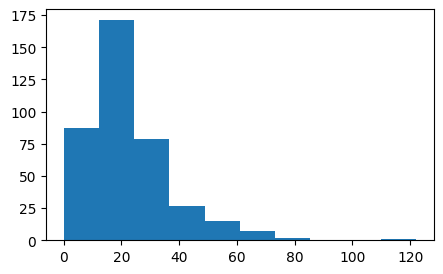

In [156]:
##### print the quantiles and hist the unspMat value at center
# print(np.quantile(np.array(centers)[:,3], np.linspace(0.1, 1, num=10))) # comment this out to save time

fig, ax = plt.subplots(1,1, figsize=(5,3))
n, bins, patches = ax.hist(np.array(centers)[:,3])

In [157]:
##### keep cells with unspMat value at center > q 
# where q is 95% quantile of unspMat on the tile
# this is step is quanlity control, filter out cells with small unspliced value at detected center
q = np.quantile(unspMat_t, 0.95)
print('q =', q)

unsp_seg_t_ = unsp_seg_t
centers_bkp = centers

print(unsp_seg_t.cell.nunique())
unsp_seg_t = unsp_seg_t[unsp_seg_t.centerMax>q]
print(unsp_seg_t.cell.nunique())

print(np.array(centers_bkp).shape)
print(np.array(centers).shape)
centers2 = np.array(centers)[np.array(centers)[:,3]>q,:]
print(centers2.shape)

q = 25.0
389
122
(389, 4)
(389, 4)
(122, 4)


In [158]:
##### keep cells with spMat value at center < q 
# where q is 95% quantile of spMat on the tile
# this is step is quanlity control, filter out cells with large spliced value at detected center
q = np.quantile(spMat_t, 0.95)
print('q =', q)

centers3 = []
for i in range(centers2.shape[0]):
    if spMat_t[centers2[i,0], centers2[i,1]] < q:
        centers3.append(centers2[i,:])
centers3 = np.array(centers3)
print(centers2.shape)
print(centers3.shape)

q = 336.0
(122, 4)
(93, 4)


In [159]:
##### find cell center for df_seg_t

centers = centers3 # <<<<< centers after QC

# add cell center to df_seg_t
data = df_seg_t.cell.tolist()
keys = np.array(centers)[:,2]
vals = np.array(centers)[:,:2]
memo = defaultdict(lambda: (0, 0))
for k, v in zip(keys, vals):
    if k not in memo:
        memo[k] = v
    else:
        raise ValueError('duplicated keys')

res0 = list(map(lambda x: memo[x][0], data))
res1 = list(map(lambda x: memo[x][1], data))

print(len(res0), len(data), len(keys), len(vals))

# append
df_seg_t['centerX'] = np.array(res0)
df_seg_t['centerY'] = np.array(res1)
print(df_seg_t.head())

1340148 1340148 93 93
    geneID  tile      x      y  umi  cell  centerX  centerY
9     Xkr4  2119  15415  12910    1   922        0        0
63    Xkr4  2119   7335  17544    1  1505        0        0
91    Xkr4  2119   5500   4874    1  1644        0        0
100   Xkr4  2119  21663   4800    1   487        0        0
133   Xkr4  2119  16120  18758    1   838        0        0


/tmp/ipykernel_3942/4185082631.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg_t['centerX'] = np.array(res0)
/tmp/ipykernel_3942/4185082631.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg_t['centerY'] = np.array(res1)


In [160]:
##### save df_seg_t, unsp_seg_t, centers (after QC)
outfile = 'output_step4/crop_tile'+str(t)+'.pkl'
# save
pickle_dict = {}
pickle_dict['df_seg_'+str(t)] = df_seg_t
pickle_dict['unsp_seg_'+str(t)] = unsp_seg_t
pickle_dict['sp_seg_'+str(t)] = sp_seg_t
pickle_dict['centers_'+str(t)] = centers
with open(outfile, 'wb') as f:
    pickle.dump(pickle_dict, f)